In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('Advertising.csv')
df.head()

,TV,radio,newspaper,sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [4]:
X = df.drop('sales', axis=1)
y=df['sales']

In [5]:
from sklearn.preprocessing import PolynomialFeatures

In [6]:
poly_converter = PolynomialFeatures(degree=3, include_bias=False)
poly_features = poly_converter.fit_transform(X)

In [7]:
from sklearn.model_selection import train_test_split

In [33]:
X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
from sklearn.linear_model import ElasticNetCV

In [37]:
elastic_model = ElasticNetCV(eps=0.001, 
                             n_alphas=100, 
                             l1_ratio=[.1, .5, .7, .9, .95, .99, 1], 
                             max_iter=1000000)

In [38]:
elastic_model.fit(X_train_scaled, y_train)
test_predictions = elastic_model.predict(X_test_scaled)

In [39]:
data = pd.DataFrame({
    'iteration': range(1, len(y_test) + 1),
    'predictions': test_predictions,
    'y_test': y_test
})

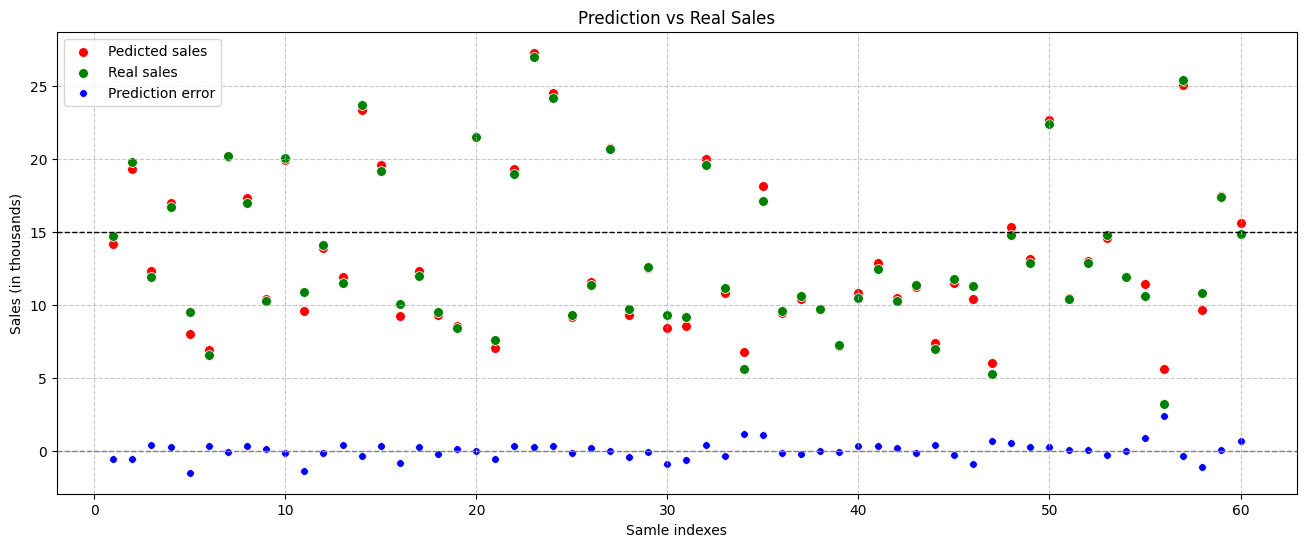

In [40]:
plt.figure(figsize=(16, 6))

sns.scatterplot(x='iteration', y='predictions', data=data, color='red', s=50, label='Pedicted sales')
sns.scatterplot(x='iteration', y='y_test', data=data, color='green', s=50, label='Real sales')
plt.axhline(y=15, color='black', linestyle='--', linewidth=1)

data['error'] = data['predictions'] - data['y_test']
sns.scatterplot(x='iteration', y='error', data=data, color='blue', s=30, label='Prediction error')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

plt.title('Prediction vs Real Sales')
plt.xlabel('Samle indexes')
plt.ylabel('Sales (in thousands)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.show()

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [43]:
MAE = mean_absolute_error(y_test, test_predictions)
RMSE = np.sqrt(mean_squared_error(y_test, test_predictions))

Degree=1, CV RMSE=1.8160, Test RMSE=1.5422, Best alpha=0.0915650077992292, l1_ratio=1.0
Degree=2, CV RMSE=0.6752, Test RMSE=0.6575, Best alpha=0.008055973939899822, l1_ratio=1.0
Degree=3, CV RMSE=0.6305, Test RMSE=0.6063, Best alpha=0.004943070909225831, l1_ratio=1.0
Degree=4, CV RMSE=0.6030, Test RMSE=0.5892, Best alpha=0.004943070909225831, l1_ratio=1.0


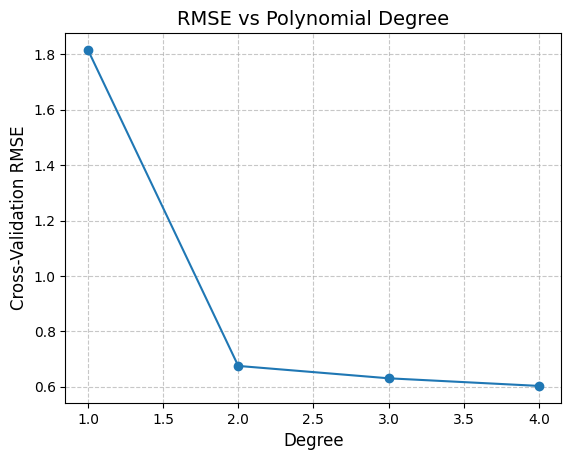

In [44]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('Advertising.csv')
X = df.drop('sales', axis=1)
y = df['sales']

# Диапазон степеней для тестирования
degrees = [1, 2, 3, 4]
rmse_scores = []

# Эксперимент для каждого degree
for degree in degrees:
    # Полиномиальные признаки
    poly_converter = PolynomialFeatures(degree=degree, include_bias=False)
    poly_features = poly_converter.fit_transform(X)

    # Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(poly_features, y, test_size=0.3, random_state=101)

    # Масштабирование
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ElasticNetCV
    elastic_model = ElasticNetCV(
        eps=0.001,
        l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1],
        n_alphas=100,
        max_iter=1000000,
        cv=5,
        random_state=101
    )
    elastic_model.fit(X_train_scaled, y_train)

    # Кросс-валидация
    cv_scores = -cross_val_score(elastic_model, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse_cv = np.sqrt(np.mean(cv_scores))
    rmse_scores.append(rmse_cv)

    # Предсказания и оценка на тестовых данных
    test_predictions = elastic_model.predict(X_test_scaled)
    rmse_test = np.sqrt(mean_squared_error(y_test, test_predictions))
    print(f"Degree={degree}, CV RMSE={rmse_cv:.4f}, Test RMSE={rmse_test:.4f}, Best alpha={elastic_model.alpha_}, l1_ratio={elastic_model.l1_ratio_}")

# Визуализация
plt.plot(degrees, rmse_scores, marker='o')
plt.title('RMSE vs Polynomial Degree', fontsize=14)
plt.xlabel('Degree', fontsize=12)
plt.ylabel('Cross-Validation RMSE', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()